In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import maxflow


def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.show()

## Task 3.
Denoise the binary image using a Markov random field.  For cut, use max-flow/min-cutalgorithm.  Read a noisy binary imagenoise.png

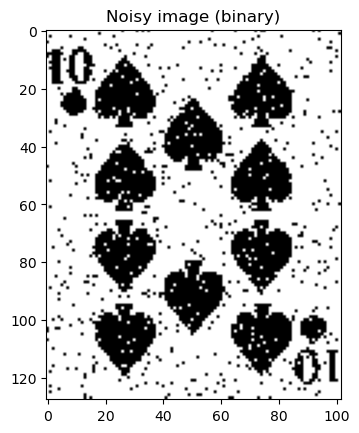

Noisy Img shape: (128, 102)
Noisy Img dtype: uint8 <--- we have to convert it to float as in the provided template maxflow axepts float data type


In [2]:
# set image path
img_path = './images/noise.png'
# read imgs
noisy_img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
display_image('Noisy image (binary)', noisy_img)

print(f"Noisy Img shape: {noisy_img.shape}")
print(f"Noisy Img dtype: {noisy_img.dtype} <--- we have to convert it to float as in the provided template maxflow axepts float data type")



3.1.  Create a graph for the image using all the pixels as nodes. 



In [3]:
def unary_costs(img, label: int, rho: float):
    """
    Computes unary costs for given image and label.
    If label is 0, then it computes the unary costs for the source with respect to the rho.
    Black pixels get cost = rho and white pixels get cost = 1-rho.
    If label is 1, then it computes the unary costs for the sink with inverted logic.
    :param img: image object
    :param label: label to compute unary costs for. "source node" if label is 0, "sink node" otherwise
    :param rho: parameter for computing unary costs
    :return: unary costs
    """
    indexes_black = np.where(img == 0)
    indexes_white = np.where(img == 1)
    costs_matrix = np.zeros(img.shape)

    if label == 0:
        costs_matrix[indexes_black] = rho
        costs_matrix[indexes_white] = 1 - rho
    else:
        costs_matrix[indexes_black] = 1 - rho
        costs_matrix[indexes_white] = rho
    return -np.log(costs_matrix)

def pairwise_costs(img, pairwise_cost_same: float, pairwise_cost_diff: float, direction: str):
    """
    Computes pairwise costs for given image.
    :param img: image object
    :param pairwise_cost_same: pairwise costs for same labels
    :param pairwise_cost_diff: pairwise costs for different labels
    :param direction: direction of the pairwise costs. "horizontal" or "vertical"
    :return: pairwise costs
    """
    pairwise_costs_matrix = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if direction == "horizontal":
                if j < img.shape[1] - 1:
                    if img[i, j] == img[i, j-1]:
                        pairwise_costs_matrix[i, j] = pairwise_cost_same
                    else:
                        pairwise_costs_matrix[i, j] = pairwise_cost_diff
                else:
                    pairwise_costs_matrix[i, j] = 0
            else:
                if i < img.shape[0] - 1:
                    if img[i, j] == img[i-1, j]:
                        pairwise_costs_matrix[i, j] = pairwise_cost_same
                    else:
                        pairwise_costs_matrix[i, j] = pairwise_cost_diff
                else:
                    pairwise_costs_matrix[i, j] = 0

    return pairwise_costs_matrix

In [4]:
rho=0.7
pairwise_cost_same=0.005
pairwise_cost_diff=0.35

# convert img to float32 and normalize it
img = noisy_img.astype(float) / 255

# 1) Define Graph
g = maxflow.Graph[float]()
# 2) Add pixels as nodes. nodeids has the identifiers of the nodes in the grid.
# Note that nodeids.shape == img.shape
nodeids = g.add_grid_nodes(img.shape)


Each pixel (node) are connected to the “source node” and the “sink node” with directed edges as well as the directed edges between its left, top, right and bottom neighboring pixel.

In [11]:
def question_3(img, rho, pairwise_cost_same, pairwise_cost_diff):
    
    # convert img to float32 and normalize it
    img = img.astype(float) / 255
    ### Create Graph
    g = maxflow.Graph[float]()

    ### Add pixels as nodes
    nodeids = g.add_grid_nodes(img.shape)

    ### Compute Unaray cost
    unaries_source = unary_costs(img, 0, rho)
    unaries_sink = unary_costs(img, 1, rho)

    ### Add terminal edges
    g.add_grid_tedges(nodeids, unaries_source, unaries_sink)

    ### Add Node edges
    # vertical direction
    g_struct_v = np.array([[0, 1, 0],
                          [0, 0, 0],
                          [0, 0, 0]])
    pairwise_costs_v = pairwise_costs(img, pairwise_cost_same=pairwise_cost_same, pairwise_cost_diff=pairwise_cost_diff, direction="vertical")
    g.add_grid_edges(nodeids, weights=pairwise_costs_v, structure=g_struct_v, symmetric=True)

    # horizontal direction
    g_struct_h = np.array([[0, 0, 0],
                          [1, 0, 0],
                          [0, 0, 0]])
    pairwise_costs_h = pairwise_costs(img, pairwise_cost_same=pairwise_cost_same, pairwise_cost_diff=pairwise_cost_diff, direction="horizontal")
    g.add_grid_edges(nodeids, weights=pairwise_costs_h, structure=g_struct_h, symmetric=True)
    # (Keep in mind the stucture of neighbourhood and set the weights according to the pairwise potential)

    ### Maxflow
    g.maxflow()

    segments_matrix  = g.get_grid_segments(nodeids)

    denoised_img = np.int_(np.logical_not(segments_matrix)*255).astype('uint8') # convert to uint8 [0,255]
    
    display_image('Noisy image (binary)', img, 'Denoised img (pairwise_cost_diff=0.2)', denoised_img)
    
    # return denoised_img

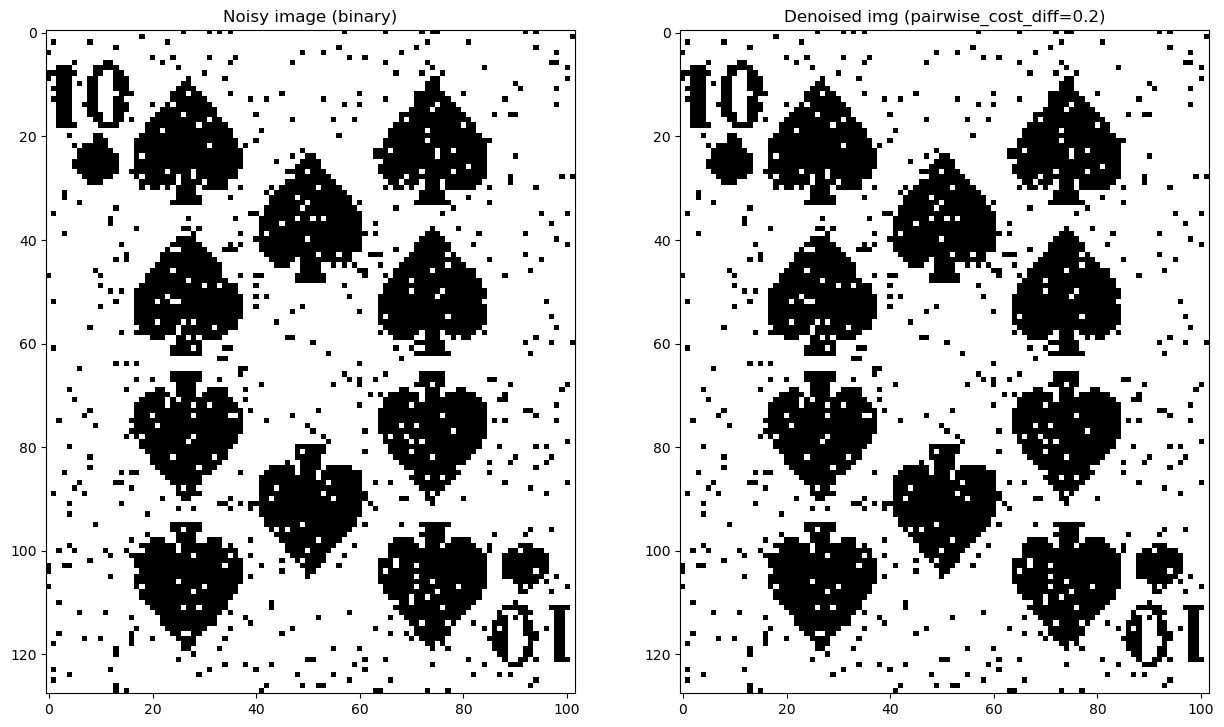

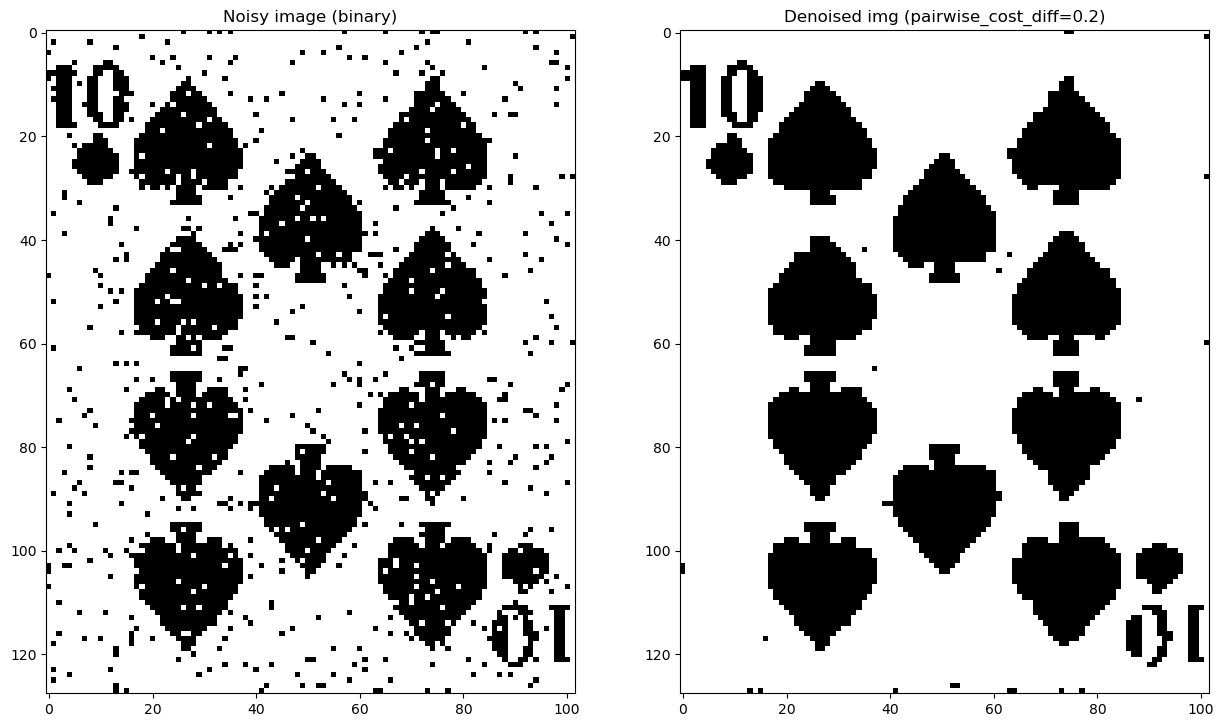

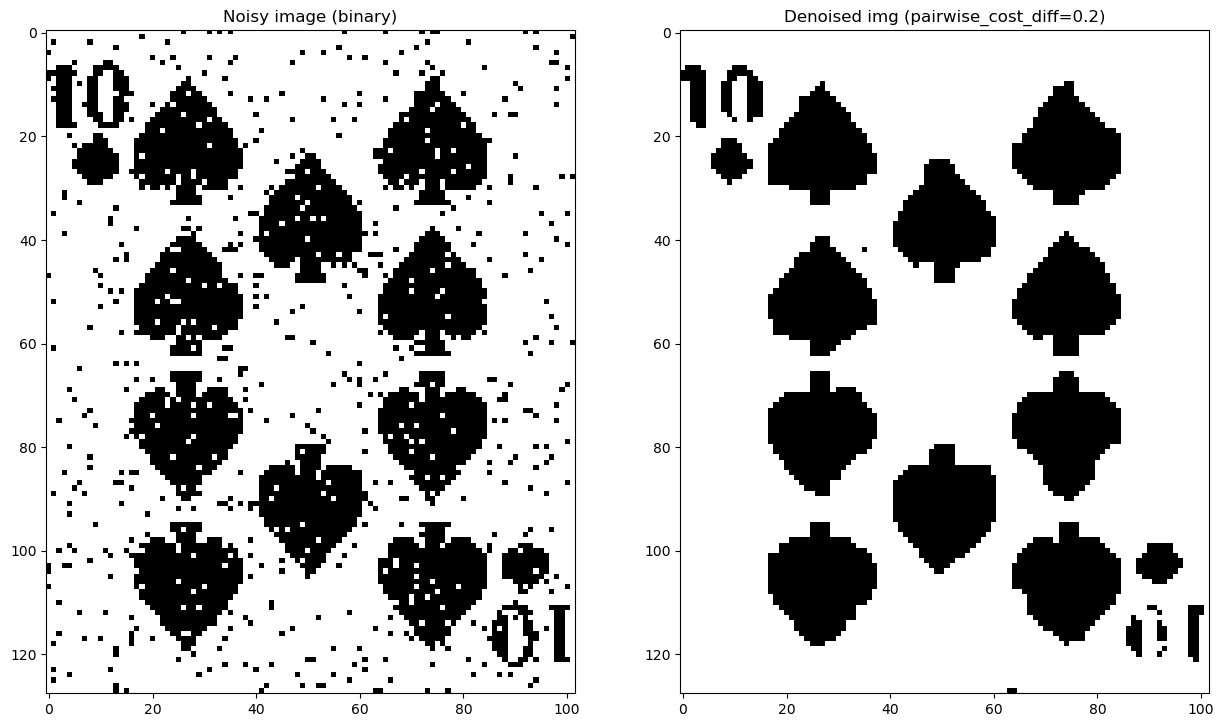

In [10]:
# Call solution for question 3
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.2)
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.35)
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.55)

Seems like pairwise_cost_diff=0.2 has no impact